In [21]:
import tstrippy
import h5py
import astropy.units as u
import astropy.coordinates as coord
import numpy as np
import sys
sys.path.append('../')
import path_handler as ph
import yaml
import h5py
import matplotlib.pyplot as plt

In [23]:
tstrippy.Parsers.potential_parameters.G

4.300917270036279e-06

In [24]:
M = 1e5
halfmass = 5e-3
G=tstrippy.Parsers.potential_parameters.G
NP = int(1e5)
x,y,z,vx,vy,vz=tstrippy.ergodic.isotropicplummer(G,M,halfmass,NP)

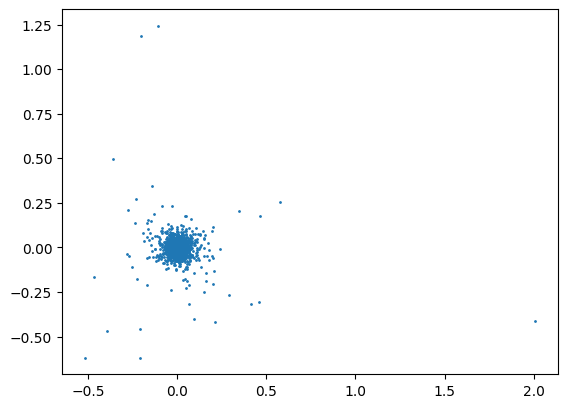

In [25]:
fig,axis=plt.subplots(1,1)
axis.scatter(x,y,s=1,alpha=1)
std_x=np.std(x)
std_y=np.std(y)
axis.set_aspect('equal')

In [12]:
std_x,std_y

(0.010452701758186283, 0.020883607611959103)

In [2]:
def extract_GC_observables(filehdf5,montecarlokey,):
    RA          =   filehdf5[montecarlokey]['RA'][0]        *u.Unit(filehdf5.attrs['RA'])
    DEC         =   filehdf5[montecarlokey]['DEC'][0]       *u.Unit(filehdf5.attrs['DEC'])
    rh_m        =   filehdf5[montecarlokey]['rh_m'][0]      *u.Unit(filehdf5.attrs['rh_m'])
    Mass        =   filehdf5[montecarlokey]['Mass'][0]      *u.Unit(filehdf5.attrs['Mass'])
    Rsun        =   filehdf5[montecarlokey]['Rsun'][0]      *u.Unit(filehdf5.attrs['Rsun'])
    RV          =   filehdf5[montecarlokey]['RV'][0]        *u.Unit(filehdf5.attrs['RV'])
    mualpha     =   filehdf5[montecarlokey]['mualpha'][0]   *u.Unit(filehdf5.attrs['mualpha'])
    mu_delta    =   filehdf5[montecarlokey]['mu_delta'][0]  *u.Unit(filehdf5.attrs['mu_delta'])
    return  Mass,rh_m,RA,DEC,Rsun,RV,mualpha,mu_delta

def extract_all_GC_observables(GCnames,montecarlokey):
    assert(isinstance(GCnames,list))
    assert(isinstance(montecarlokey,str))
    Masses,rh_mes,RAes,DECes,Rsunes,RVes,mualphaes,mu_deltaes=[],[],[],[],[],[],[],[]
    for i in range(len(GCnames)):
        filename=ph.MonteCarloObservables(GCnames[i])
        with h5py.File(filename,'r') as filehdf5:
            Mass,rh_m,RA,DEC,Rsun,RV,mualpha,mu_delta=extract_GC_observables(filehdf5,montecarlokey)
            Masses.append(Mass)
            rh_mes.append(rh_m)
            RAes.append(RA)
            DECes.append(DEC)
            Rsunes.append(Rsun)
            RVes.append(RV)
            mualphaes.append(mualpha)
            mu_deltaes.append(mu_delta)
    return Masses,rh_mes,RAes,DECes,Rsunes,RVes,mualphaes,mu_deltaes

In [10]:
# get the integration parameters
def get_backward_forward_integration_parameters(config):
    unitbasis   =   tstrippy.Parsers.potential_parameters.unitbasis
    timestep    =   u.quantity.Quantity(config['timestep'])
    forwardtime =   u.quantity.Quantity(config['forwardtime'])
    backwardtime=   u.quantity.Quantity(config['backwardtime'])
    NSTEP_b     =   int(backwardtime.value/timestep.value)
    NSTEP_f     =   int(forwardtime.value/timestep.value)
    timestep    =   timestep.to(unitbasis['time'])
    forwardtime =   forwardtime.to(unitbasis['time'])
    backwardtime=   backwardtime.to(unitbasis['time'])
    
    tf          =   np.linspace(0,forwardtime.value,NSTEP_f+1)
    tb          =  -np.linspace(0,backwardtime.value,NSTEP_b+1)
    tb          =   tb[::-1]
    t           =   np.concatenate((tb[:-1],tf))
    return t, (backwardtime, NSTEP_b, timestep), (forwardtime, NSTEP_f, timestep)

In [3]:
# import the configuration file
with open("config.yaml", 'r') as stream:
    config = yaml.safe_load(stream)

In [8]:
# import the galactic reference frame
refframe=tstrippy.Parsers.potential_parameters.MWreferenceframe()
# import the on potential parameters
if config["MWpotential"]=="pouliasis2017pii":
    MWparams=tstrippy.Parsers.potential_parameters.pouliasis2017pii()
else:
    print("potential not found")

In [9]:
Mass,rh_m,RA,DEC,Rsun,RV,mualpha,mu_delta=extract_all_GC_observables(config['GCname'],config['montecarlokey'])
gc_sky=coord.SkyCoord(ra=RA,dec=DEC,pm_ra_cosdec=mualpha,pm_dec=mu_delta,radial_velocity=RV, distance=Rsun, frame='icrs')
gc_galcentric=gc_sky.transform_to(refframe)

In [11]:
# set up the time parameters
t, back, forward=get_backward_forward_integration_parameters(config)

In [12]:
## DO THE FORWARD INTEGRATION
tstrippy.lib.integrator.setstaticgalaxy(config['MWpotential'],MWparams) 
tstrippy.lib.integrator.setintegrationparameters(0,forward[2].value,forward[1])
tstrippy.lib.integrator.setinitialkinematics(
    gc_galcentric.x.to(u.kpc).value,
    gc_galcentric.y.to(u.kpc).value,
    gc_galcentric.z.to(u.kpc).value,
    gc_galcentric.v_x.to(u.km/u.s).value,
    gc_galcentric.v_y.to(u.km/u.s).value,
    gc_galcentric.v_z.to(u.km/u.s).value)
xt_f,yt_f,zt_f,vxt_f,vyt_f,vzt_f=tstrippy.lib.integrator.leapfrogintime(forward[1],len(config['GCname']))
tstrippy.lib.integrator.deallocate()

In [13]:
## DO THE BACKWARD INTEGRATION
tstrippy.lib.integrator.setstaticgalaxy(config['MWpotential'],MWparams) 
tstrippy.lib.integrator.setintegrationparameters(0,back[2].value,back[1])
tstrippy.lib.integrator.setinitialkinematics(
    gc_galcentric.x.to(u.kpc).value,
    gc_galcentric.y.to(u.kpc).value,
    gc_galcentric.z.to(u.kpc).value,
    -gc_galcentric.v_x.to(u.km/u.s).value,
    -gc_galcentric.v_y.to(u.km/u.s).value,
    -gc_galcentric.v_z.to(u.km/u.s).value)
xt_b,yt_b,zt_b,vxt_b,vyt_b,vzt_b=tstrippy.lib.integrator.leapfrogintime(back[1],len(config['GCname']))
# flip the order and the sign of the velocities
tstrippy.lib.integrator.deallocate()

In [28]:
xt_b, yt_b, zt_b = xt_b[:,::-1], yt_b[:,::-1], zt_b[:,::-1]
vxt_b,vyt_b,vzt_b=-vxt_b[:,::-1],-vyt_b[:,::-1],-vzt_b[:,::-1]
x = np.concatenate((xt_b,xt_f[:,1:]),axis=1)
y = np.concatenate((yt_b,yt_f[:,1:]),axis=1)
z = np.concatenate((zt_b,zt_f[:,1:]),axis=1)
vx= np.concatenate((vxt_b,vxt_f[:,1:]),axis=1)
vy= np.concatenate((vyt_b,vyt_f[:,1:]),axis=1)
vz= np.concatenate((vzt_b,vzt_f[:,1:]),axis=1)

In [30]:
outarray=np.zeros((6,len(config['GCname']),len(t)))
outarray[0]=x
outarray[1]=y
outarray[2]=z
outarray[3]=vx
outarray[4]=vy
outarray[5]=vz


In [35]:



outfilename= ph.temporary_gc_orbits(config['MWpotential'],config["montecarlokey"],"phase-space")
np.save(outfilename,outarray)
outfilename= ph.temporary_gc_orbits(config['MWpotential'],config["montecarlokey"],"t")
np.save(outfilename,t)



4